In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
os.environ["WORLD_SIZE"] = "1"
os.environ["RANK"] = "0"
os.environ["LOCAL_RANK"] = "0"
os.environ["MASTER_ADDR"] = "localhost"
os.environ["MASTER_PORT"] = "9994"

import torch
from transformers import AutoProcessor, LlavaForConditionalGeneration
from peft import PeftModel

model_id = "llava-hf/llava-1.5-7b-hf"
lora_path = "./sft_llava_lora"  # or "./sft_llava_lora/checkpoint-625" for specific checkpoint

# Load base model
base_model = LlavaForConditionalGeneration.from_pretrained(
    model_id,
    torch_dtype=torch.float32,
    device_map={"": 0},
)

# Load LoRA adapter on top
model = PeftModel.from_pretrained(base_model, lora_path)
model.eval()

# Load processor
processor = AutoProcessor.from_pretrained(model_id)
processor.tokenizer.pad_token = processor.tokenizer.eos_token

print("Model loaded successfully!")

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/686 [00:00<?, ?it/s]

The image processor of type `CLIPImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. 


Model loaded successfully!


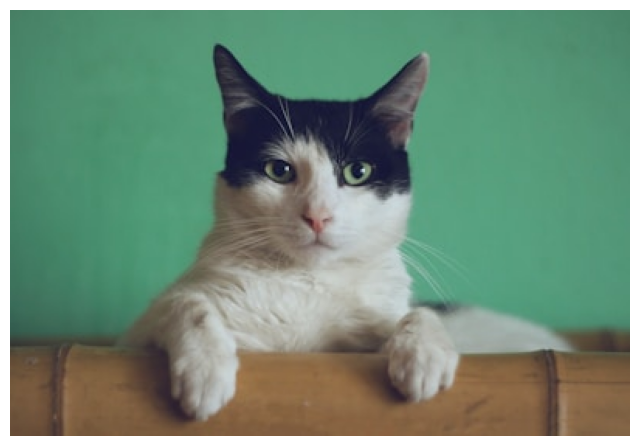

Question: What animal is in this image? Describe it.
Response: A cat is in this image. It is a black and white cat with green eyes. The cat is sitting on a wooden ledge or a fence. It appears to be looking at the camera. The cat's fur is white, and it has a striped pattern. The cat's eyes are wide open, and it seems to be staring directly at the camera.



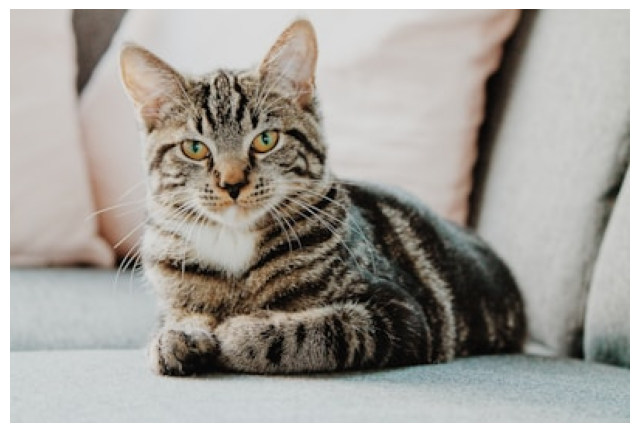

Question: Describe this image in detail.
Response: The image features a small, fluffy, and striped cat sitting on a couch. The cat is positioned in the center of the couch, occupying a significant portion of the couch's surface. The couch is located in a living room, providing a comfortable spot for the cat to relax. The scene captures the cat's cozy and content demeanor as it lays on the couch.



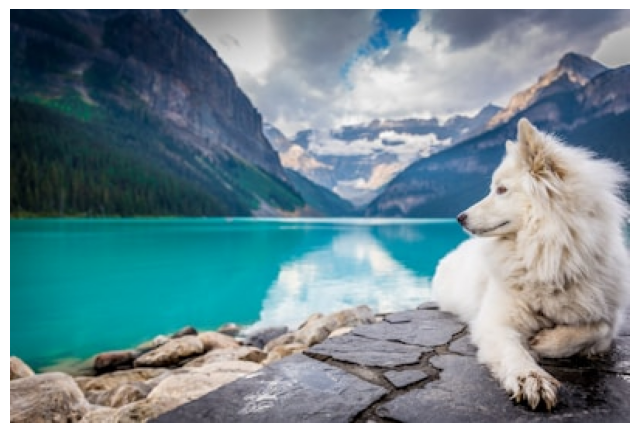

Question: What is happening in this image?
Response: In the image, a white dog is sitting on a rock near a body of water, possibly a lake or a river. The dog appears to be enjoying the view and the surroundings. The scene is set against a backdrop of mountains, creating a picturesque and serene atmosphere. The dog's presence adds a sense of companionship and enjoyment to the natural landscape.



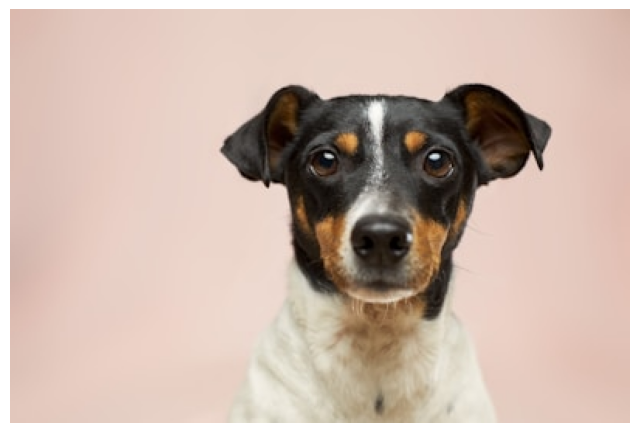

Question: What do you see?
Response: The image features a black and white dog with a brown nose, sitting in front of a pink background. The dog appears to be looking directly at the camera, capturing the viewer's attention. The dog is positioned towards the center of the image, and its size is noticeable, indicating that it might be a medium-sized breed. The pink background provides a contrasting and vibrant backdrop for the dog, making the scene visually appealing.



In [2]:
from PIL import Image
import requests
import matplotlib.pyplot as plt
import torch

def evaluate_and_display(test_images):
    for url, question in test_images:
        try:
            headers = {"User-Agent": "Mozilla/5.0"}
            response = requests.get(url, stream=True, headers=headers)
            image = Image.open(response.raw).convert("RGB")
            
            prompt = f"USER: <image>\n{question}\nASSISTANT:"
            inputs = processor(text=prompt, images=image, return_tensors="pt").to(model.device)
            
            with torch.no_grad():
                output = model.generate(**inputs, max_new_tokens=256, do_sample=False)
            
            result = processor.tokenizer.decode(output[0], skip_special_tokens=True)
            if "ASSISTANT:" in result:
                result = result.split("ASSISTANT:")[-1].strip()
            
            # Display image
            fig, ax = plt.subplots(figsize=(8, 6))
            ax.imshow(image)
            ax.axis("off")
            plt.show()
            
            # Print Q&A
            print(f"Question: {question}")
            print(f"Response: {result}")
            print("=" * 60)
            print()
            
        except Exception as e:
            print(f"Error with {url}: {e}")

# Test images
test_images = [
    ("https://images.unsplash.com/photo-1514888286974-6c03e2ca1dba?w=400",
     "What animal is in this image? Describe it."),
    ("https://images.unsplash.com/photo-1518791841217-8f162f1e1131?w=400", 
     "Describe this image in detail."),
    ("https://images.unsplash.com/photo-1504208434309-cb69f4fe52b0?w=400",
     "What is happening in this image?"),
    ("https://images.unsplash.com/photo-1561037404-61cd46aa615b?w=400",
     "What do you see?"),
]

evaluate_and_display(test_images)